# Ledouble Loïc (SNS) - Tall Abdoulaye (SNS) - Richard Ilona (CSM)

### Chargement des packages

In [1]:
# !pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

In [2]:
# Pour traitement des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdata

# Pour réseaux de neurones
from tensorflow import keras
from tensorflow.keras import layers

# Pour modèles de machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,make_scorer,f1_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Fonctions utilisées pour le préprocessing des données
from preprocessing import *

# Fonctions utilisées pour l'entraînement des modèles
from fonctions_utiles import *

In [3]:
import os

# Création du dossier pour sauvegarder les graphiques de comparaison
os.makedirs("model_comparison", exist_ok=True)


### Contexte

Des études récentes montrent que les maladies inflammatoires de l'intestin (MII) s'accompagnent de perturbations du microbiote intestinal. Le séquençage ARN du microbiote permet d'identifier et de comparer les différentes bactéries présentes dans l'intestin.

Dans ce projet, nous analyserons les données OTU issues du séquençage, ainsi qu'une partie des métadonnées des patients, pour entraîner plusieurs modèles de machine learning capables de prédire si un individu est sain ou atteint d'une MII. 

### Description des données

Les données disponibles sont organisés en trois tableaux : les métadonnées des patients et la table des OTU issues du séquençage 

In [4]:
data_path = "data.Rdata" 
converted_data = rdata.read_rds(data_path)
data_df = pd.DataFrame(converted_data['meta.full'])
print(f"Dim data_df : {data_df.shape}")

otu_path = "otu.Rdata"
converted_otu = rdata.read_rds(otu_path)
otu_df = pd.DataFrame(converted_otu['otu.full'])
print(f"Dim otu_df : {otu_df.shape}")

# tax_path = "taxonomy.Rdata"
# converted_tax = rdata.read_rds(tax_path) 
# tax_df = pd.DataFrame(converted_tax['taxonomy'])
# print(f"Tax_df ---> {tax_df.shape}")


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rdata\parser\_parser.py:1239: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


Dim data_df : (284, 61)
Dim otu_df : (284, 2565)


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rdata\parser\_parser.py:1239: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


`Métadonnées` aka `data_df`: Parmi les nombreuses variables présentes dans les métadonnées (âge, sexe, traitement, localisation, type d'échantillon, etc.), seules deux seront conservées pour cette étude : l'âge et le diagnostic. Les autres variables ont été considérées comme non pertinentes pour l'objectif de prédiction et seront retirées.


La variable `diagnosis` contient différents labels : `no`, `CD`, `UC` et `IC`. La figure suivante montre que la répartition des individus est déséquilibrée.

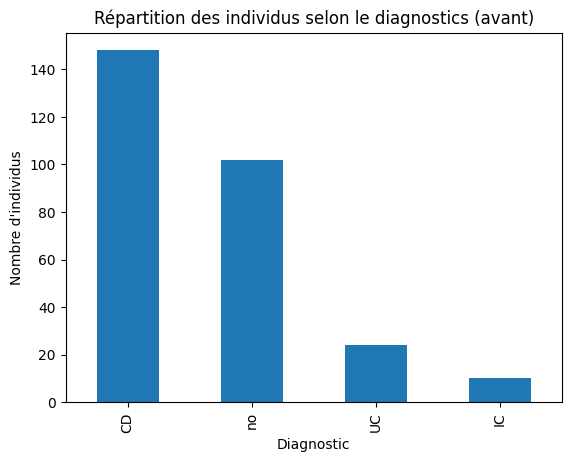

In [5]:
data_df["diagnosis"].value_counts().plot(kind="bar")
plt.ylabel("Nombre d'individus")
plt.xlabel("Diagnostic")
plt.title("Répartition des individus selon le diagnostics (avant)")
plt.show()

En raison des différences d'effectifs dans les catégories, nous allons par la suite regrouper les individus en deux catégories : `healthy` et `disease`.

`OTU`: Dans ce tableau, chaque ligne correspond à un individu et chaque colonne à une bactérie du microbiote. Les valeurs présentes dans le tableau représentent le nombre de séquences observées pour chaque bactérie chez chaque individu. 

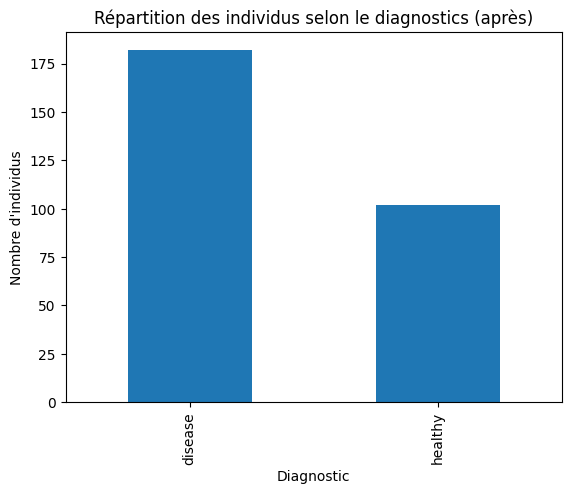

In [6]:
data_df["diagnosis"].apply(lambda s : "healthy" if s =="no" else "disease").value_counts().plot(kind="bar")
plt.ylabel("Nombre d'individus")
plt.xlabel("Diagnostic")
plt.title("Répartition des individus selon le diagnostics (après)")
plt.show()

### Modèles utilisées
 - Modèles simples
    - Regression Logistique
 - Modèles complexes
    - Random Forest
    - XGBoost
    - Réseaux de neurones

L'implémentation des codes se situent dans le fichier `fonctions_utiles.py`.

### Préprocessing

Le pré-processing s'est fait en trois étapes : 

- data_df
  - Mise en place de `sample_name` comme index de notre dataframe.
  - Récupération des colonnes `age` et `diagnosis`.
  - Transformation de la colonne `diagnosis` en miniscules.
  - Suppression des lignes avec au moins un NaN.

- otu_df
  - Suppression des échantillons faibles en profondeur (profondeur >= `12000`).
  - Récupération des OTU avec une prévalence >= `5%` et une somme totale >= `50`.
  - Transformation CLR pour normaliser les données (par ligne): +1 (pour éviter les 0) -> fermeture (proportions) -> log -> centrage (moyenne des logs soustraite).
  - Filtre post-CLR: retrait des `5%` d'OTUs a plus faible variance.
  - Faire test de student et garder les variables les plus pertinentes avec une pvalue de moins de 20%.

- Fusion
  - Jointure interne sur l'index des echantillons (`sample_name`): `merged = data_df.join(otu_df_clr, how='inner')`. On obtient donc `merged_df`.

Les fonctions utilisées pour le preprocessing se situent dans le fichier `preprocessing.py`

Chargement et preprocessing des données.

In [7]:
# Preprocessing et fusion des df
merged_df = mergin_otu_level(data_df,otu_df)

In [8]:
# Mise en place du X (représentant les variables explicatives) et du Y (représentant la variable à expliquer)
X = merged_df.drop(columns=['diagnosis'])
y = merged_df.loc[:, "diagnosis"].astype(str)

### Résultats

Pour présenter les résultats des modèles, on s'est focalisé sur les métriques suivantes : 

- L'`accuracy` : Elle représente la proportion de prédictions correctes.
    - Formule : $\frac{TP + TN}{TP + TN + FP + FN}$

- La `précision` : Elle représente la proportion de vrais positifs parmi toutes les prédictions positives.
    - Formule : $\frac{TP}{TP+FP}$

- Le `rappel` : Elle représente la proportion de vrais positifs parmi ceux qui sont réelement positifs.
    - Formule : $\frac{TP}{TP+FN}$

- Le `f1-score` : Elle représente une moyenne harmonique entre le rappel et la précision.
    - Formule : $2 \cdot \frac{precision \cdot rappel}{precision + rappel}$

- L'`auc` : Elle représente l'aire en dessous de la courbe roc.

- Le `threshold` : Il représente le seuil optimal trouvé sur la courbe roc.

- Le `fold_scores` : Il représente l'ensemble des scores du modèle sur chaque fold.

Dans le contexte de notre classification, avoir un faux négatif est plus impactant qu'avoir un faux positif car se serait ne pas detecté une personne souffrante et donc la métrique à préconiser ici serait plus le $rappel$ que la $précision$ même si cette dernière est à garder sous les radars.


In [9]:
# Création d'un nouveau dataframe pour récupérer les résultats de chaque modèle
report_df = pd.DataFrame(columns=["modèle", "accuracy", "precision", "recall", "f1-score", "auc", "threshold", "mean_fold_scores","reduction"])

# Dictionnaire pour stocker tous les résultats, y compris les données ROC
all_results = {}

In [10]:
# report_df

> Réseaux de neurones
***

------> Reduction = True
[train_model] Réduction de variables activée (seuil=mean): 338 / 1050 colonnes conservées
Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4863 - auc: 0.5318 - loss: 2.2985 - val_accuracy: 0.5135 - val_auc: 0.6599 - val_loss: 2.1785 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5342 - auc: 0.6303 - loss: 2.1601 - val_accuracy: 0.6486 - val_auc: 0.7764 - val_loss: 2.0617 - learning_rate: 0.0010
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5685 - auc: 0.6581 - loss: 2.1025 - val_accuracy: 0.7297 - val_auc: 0.8525 - val_loss: 1.9682 - learning_rate: 0.0010
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6164 - auc: 0.7431 - loss: 1.9684 - val_accuracy: 0.7568 - val_auc: 0.8758 - val_loss: 1.8921 - learning_rate: 0.0010
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6233 - auc: 0.7274 - loss: 1.9507 - val_accuracy: 0.8108 - val_auc: 0.9068 - val_lo

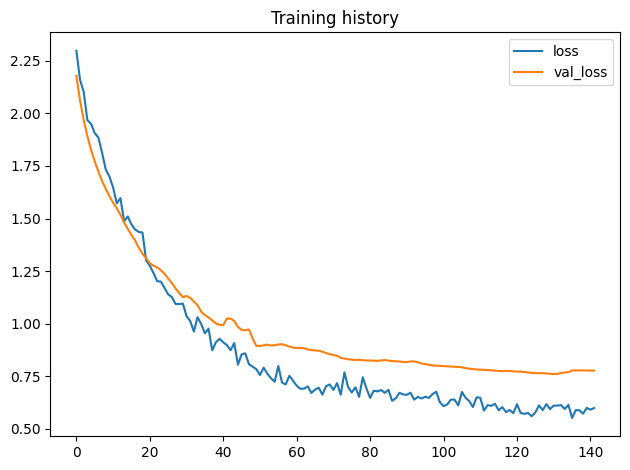

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Report NN (uncalibrated):
               precision    recall  f1-score   support

     healthy       0.69      0.62      0.65        29
     disease       0.79      0.84      0.82        50

    accuracy                           0.76        79
   macro avg       0.74      0.73      0.74        79
weighted avg       0.76      0.76      0.76        79



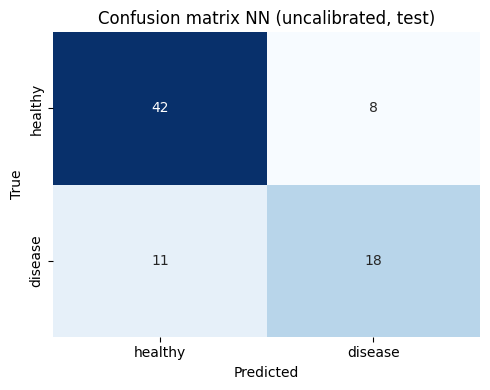

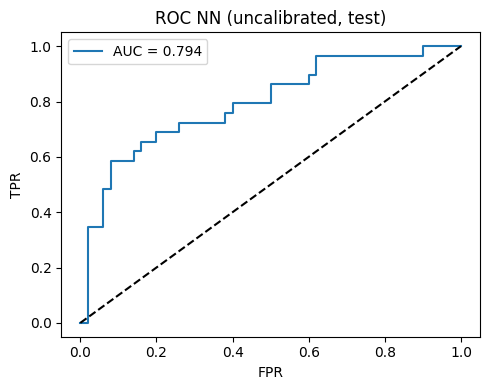

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


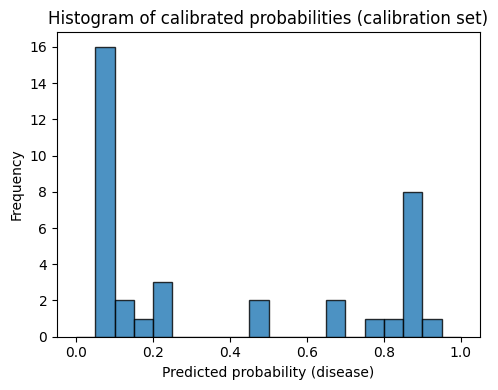

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


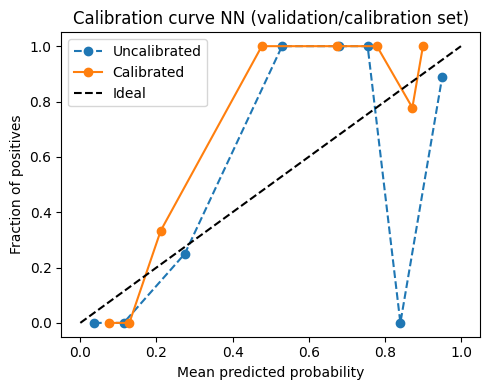

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


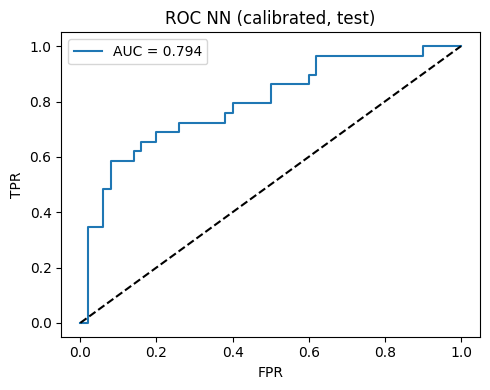

Report NN (calibrated, 0.5):
               precision    recall  f1-score   support

     healthy       0.71      0.59      0.64        29
     disease       0.78      0.86      0.82        50

    accuracy                           0.76        79
   macro avg       0.75      0.72      0.73        79
weighted avg       0.75      0.76      0.75        79



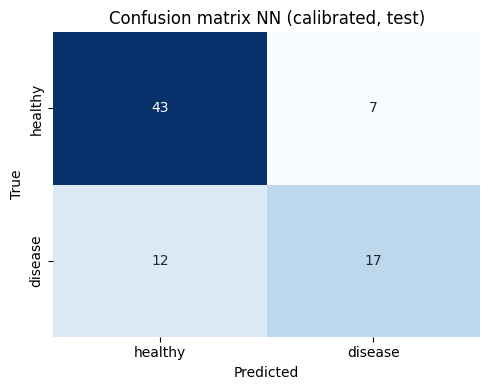

Best threshold (Youden J) NN on calib: 0.2135


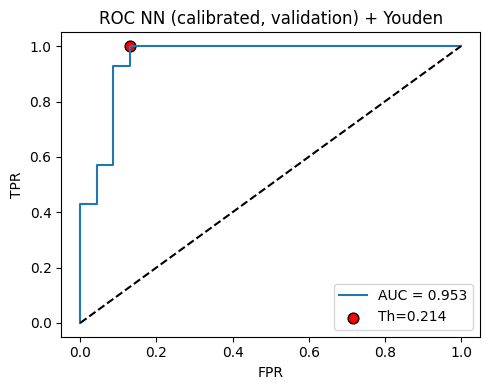

Report NN (calibrated + threshold):
               precision    recall  f1-score   support

     healthy       0.55      0.72      0.63        29
     disease       0.80      0.66      0.73        50

    accuracy                           0.68        79
   macro avg       0.68      0.69      0.68        79
weighted avg       0.71      0.68      0.69        79



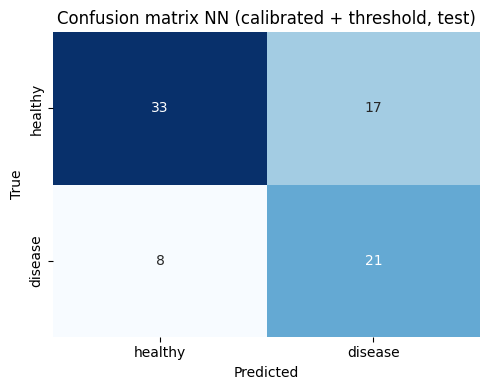


[INFO] Comparaison du rappel (disease): Non-calibré=0.621 vs Calibré+Seuil=0.724
[INFO] Le modèle calibré est meilleur ou équivalent. Utilisation des résultats calibrés.
[INFO] Calcul des scores de fold sur le modèle calibré.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


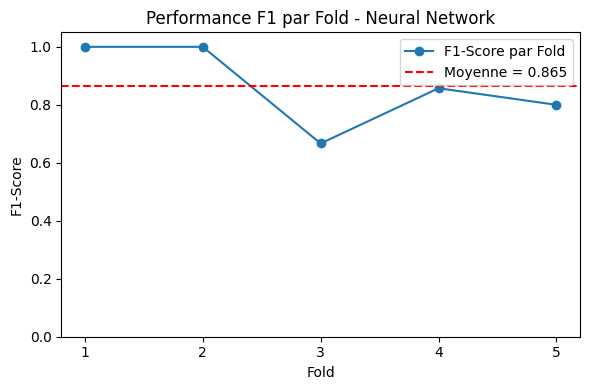

------> Reduction = False
Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.4795 - auc: 0.5073 - loss: 2.4501 - val_accuracy: 0.5946 - val_auc: 0.6770 - val_loss: 2.2123 - learning_rate: 0.0010
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5685 - auc: 0.6342 - loss: 2.2989 - val_accuracy: 0.7297 - val_auc: 0.8509 - val_loss: 2.0560 - learning_rate: 0.0010
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7055 - auc: 0.7988 - loss: 2.0828 - val_accuracy: 0.7568 - val_auc: 0.8696 - val_loss: 1.9730 - learning_rate: 0.0010
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6644 - auc: 0.7503 - loss: 2.0930 - val_accuracy: 0.7568 - val_auc: 0.8758 - val_loss: 1.9172 - learning_rate: 0.0010
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7260 - auc: 0.8177 - loss: 1.9824 - val_accuracy: 0.7297 - val_auc: 0.8866 - val_loss: 1.8707 - learning_rate: 0.0010
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - 

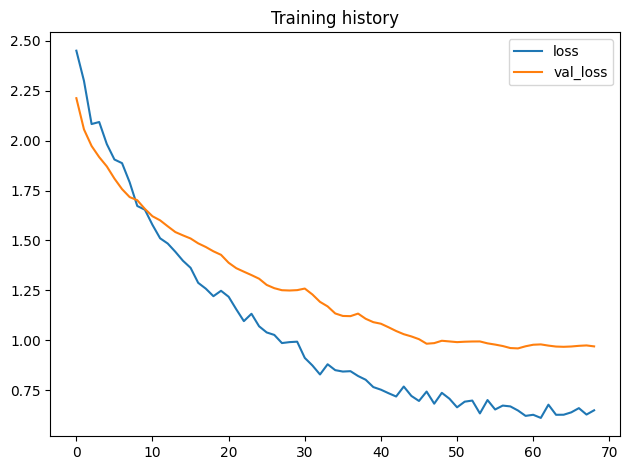

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Report NN (uncalibrated):
               precision    recall  f1-score   support

     healthy       0.72      0.79      0.75        29
     disease       0.87      0.82      0.85        50

    accuracy                           0.81        79
   macro avg       0.80      0.81      0.80        79
weighted avg       0.82      0.81      0.81        79



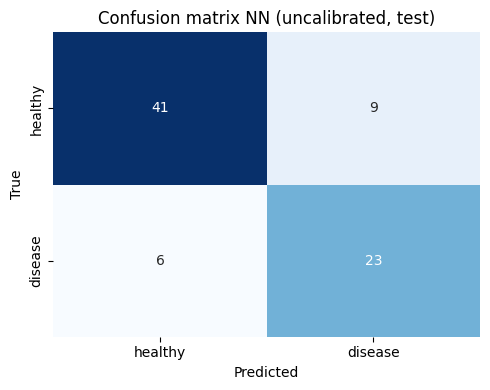

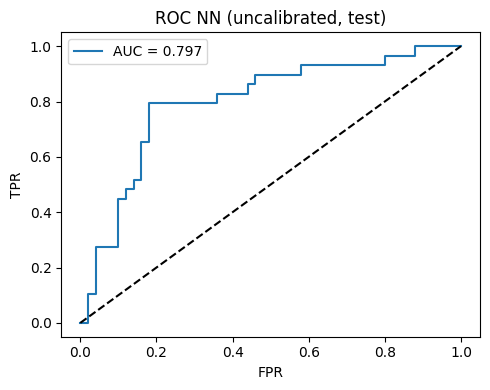

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


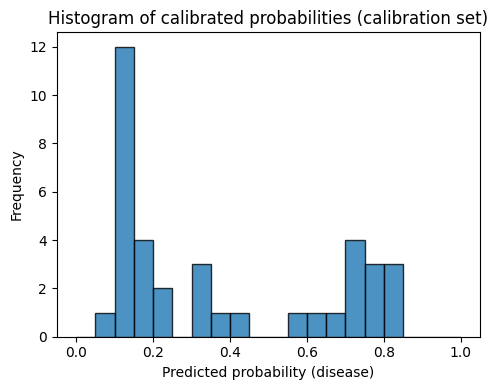

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


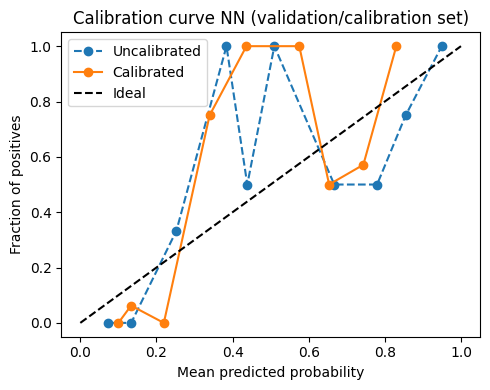

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


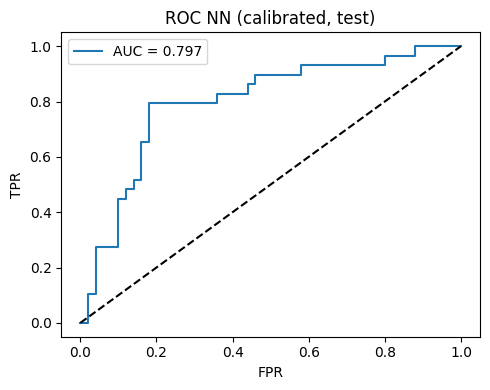

Report NN (calibrated, 0.5):
               precision    recall  f1-score   support

     healthy       0.68      0.66      0.67        29
     disease       0.80      0.82      0.81        50

    accuracy                           0.76        79
   macro avg       0.74      0.74      0.74        79
weighted avg       0.76      0.76      0.76        79



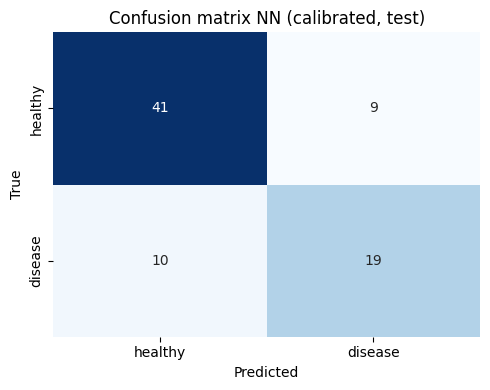

Best threshold (Youden J) NN on calib: 0.3031


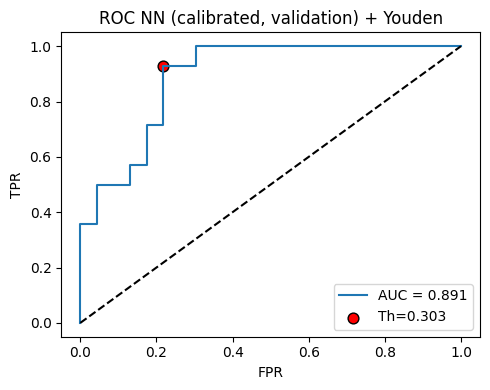

Report NN (calibrated + threshold):
               precision    recall  f1-score   support

     healthy       0.64      0.79      0.71        29
     disease       0.86      0.74      0.80        50

    accuracy                           0.76        79
   macro avg       0.75      0.77      0.75        79
weighted avg       0.78      0.76      0.76        79



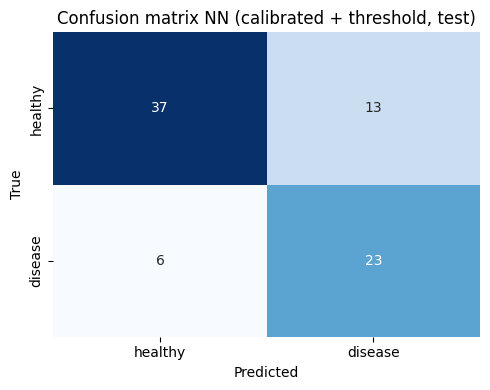


[INFO] Comparaison du rappel (disease): Non-calibré=0.793 vs Calibré+Seuil=0.793
[INFO] Le modèle calibré est meilleur ou équivalent. Utilisation des résultats calibrés.
[INFO] Calcul des scores de fold sur le modèle calibré.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


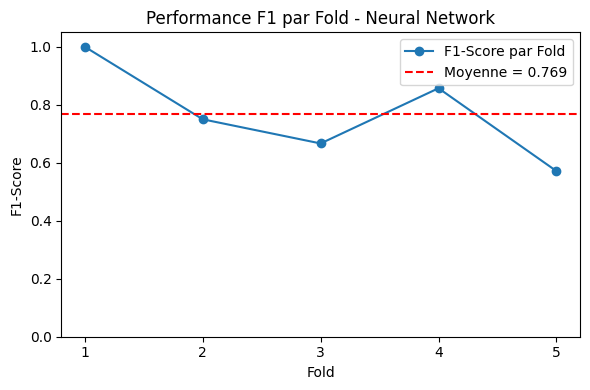

In [11]:
input_dim = merged_df.shape[1]-1 # Taille de l'entrée du réseaux de neurones

num_classes = len(merged_df["diagnosis"].value_counts()) # Nombre de classes (2)

lr = 1e-3 # Learning rate 

nn_model = build_model(input_dim,num_classes,lr) # Création du réseaux de neurones

for red in [True,False] : 
    print(f"------> Reduction = {red}")
    results_nn = train_model(nn_model,merged_df,"diagnosis",verbose=True,reduction=red)

    # Stockage des résultats complets
    all_results['NN'] = results_nn

    # Affectation de la ligne dans le dataframe
    report_df.loc[len(report_df)] = ["nn",
                                    results_nn["accuracy"],
                                    results_nn["precision"],
                                    results_nn["recall"], 
                                    results_nn["f1-score"], 
                                    results_nn["auc_calibrated"],
                                    results_nn["best_threshold"],
                                    results_nn["mean_fold_scores"],red]


 - Analyse

    - Matrice de confusion :

        - Pour la classe `disease`, les scores de `précision` et de `rappel` sont supérieur à $80$% , montrant donc que le modèle fait de bonnes prédictions pour la classe `disease` et se trompe rarement. Le F1-score atteste de cela avec une valeur de $82%$.

        - Pour la classe `healthy`, les scores sont un peu moins satisfaisant avec une précision de $68$% montrant donc que le modèle produit beaucoup de faux positifs et un rappel de $72$% étant synonyme de grand nombre de faux négatifs.

    - F1-score : 

> Régression Logistique
***

------> Reduction = True
[train_with_calibration] Reduction de features activee (seuil=moyenne): 360 / 1050 features conservees
Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.



Report LR (uncalibrated):
               precision    recall  f1-score   support

     healthy       0.70      0.48      0.57        29
     disease       0.75      0.88      0.81        50

    accuracy                           0.73        79
   macro avg       0.72      0.68      0.69        79
weighted avg       0.73      0.73      0.72        79



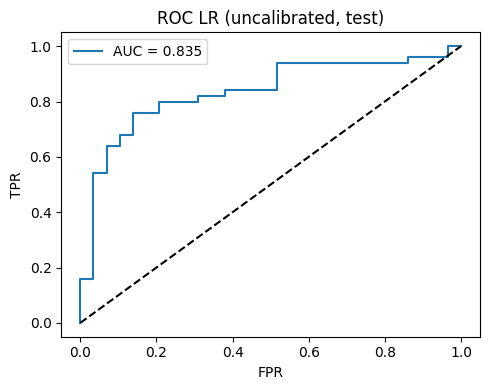

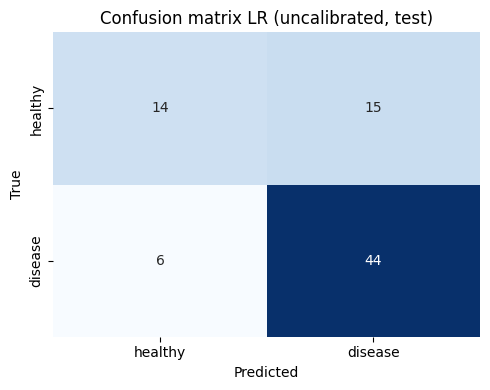

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



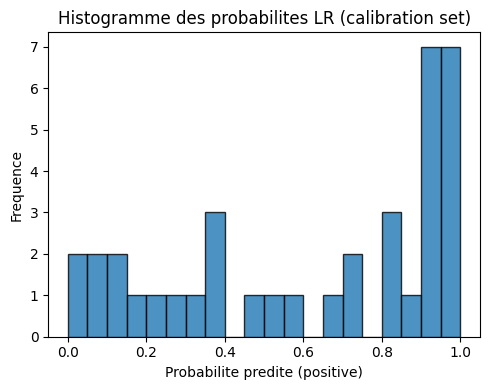

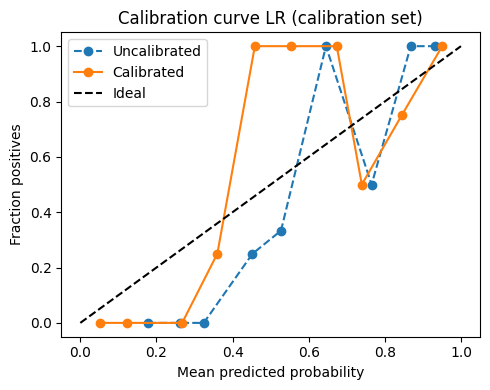

Rapport LR (calibrated):
               precision    recall  f1-score   support

     healthy       0.79      0.82      0.80        50
     disease       0.67      0.62      0.64        29

    accuracy                           0.75        79
   macro avg       0.73      0.72      0.72        79
weighted avg       0.74      0.75      0.74        79



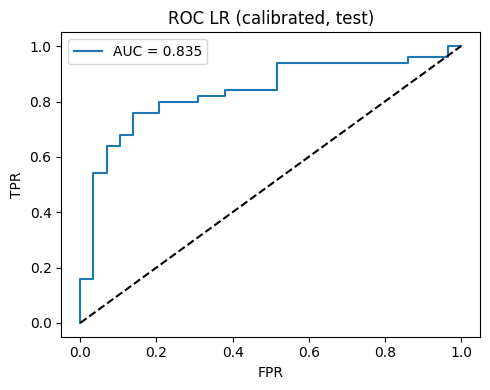

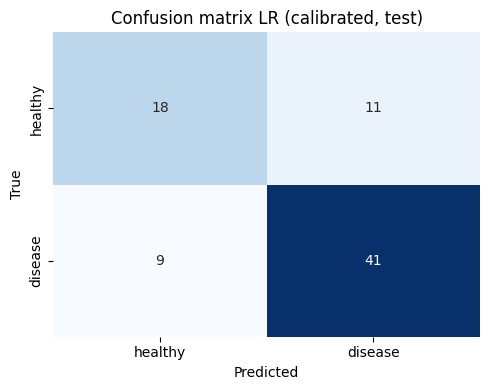

Meilleur seuil (Youden J) LR sur calib: 0.4585 | J=0.8137 | TPR=0.9565 | FPR=0.1429
Rapport LR (calibrated + threshold):
               precision    recall  f1-score   support

     healthy       0.65      0.52      0.58        29
     disease       0.75      0.84      0.79        50

    accuracy                           0.72        79
   macro avg       0.70      0.68      0.68        79
weighted avg       0.71      0.72      0.71        79



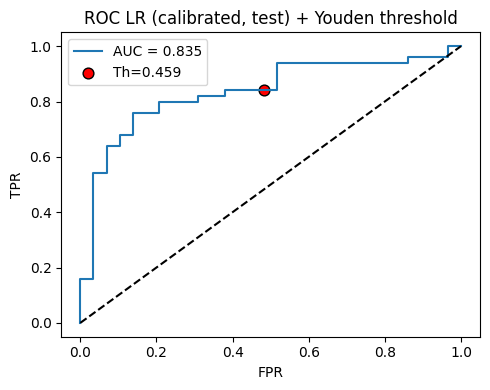

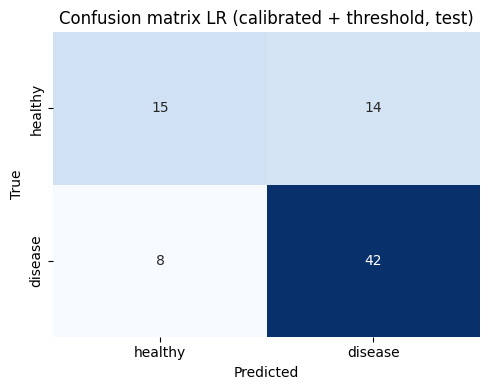


[INFO] Comparaison du rappel (disease): Non-calibre=0.880 vs Calibre+Seuil=0.840
[INFO] Le modele non-calibre est meilleur (ou le seul disponible).
[INFO] Calcul des scores de fold (F1-score) par validation croisee.


c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\ch

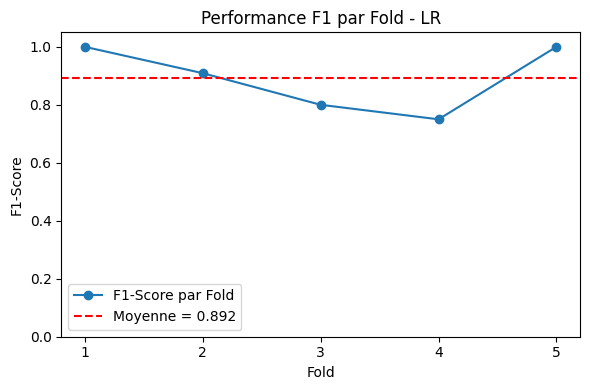

------> Reduction = False
Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1262: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.



Report LR (uncalibrated):
               precision    recall  f1-score   support

     healthy       0.80      0.41      0.55        29
     disease       0.73      0.94      0.82        50

    accuracy                           0.75        79
   macro avg       0.77      0.68      0.69        79
weighted avg       0.76      0.75      0.72        79



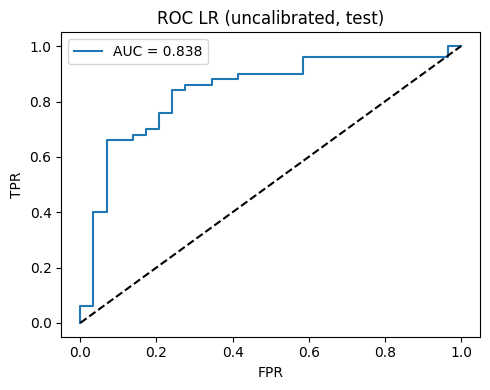

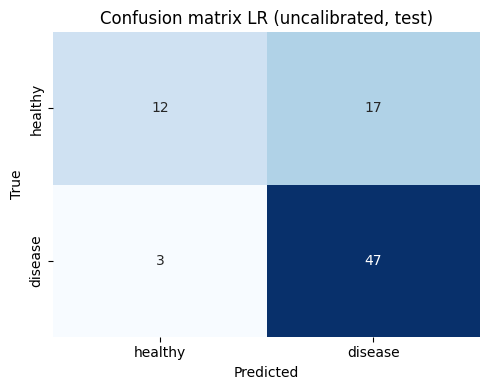

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



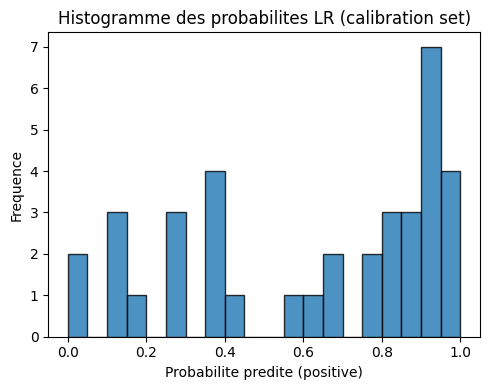

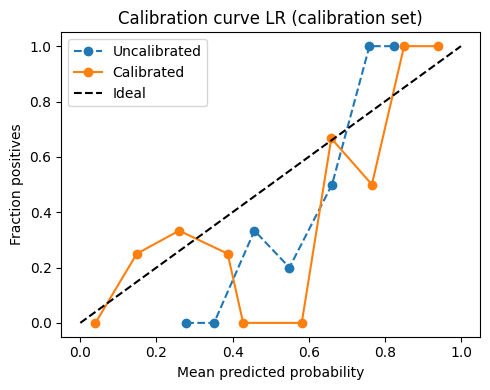

Rapport LR (calibrated):
               precision    recall  f1-score   support

     healthy       0.83      0.86      0.84        50
     disease       0.74      0.69      0.71        29

    accuracy                           0.80        79
   macro avg       0.78      0.77      0.78        79
weighted avg       0.80      0.80      0.80        79



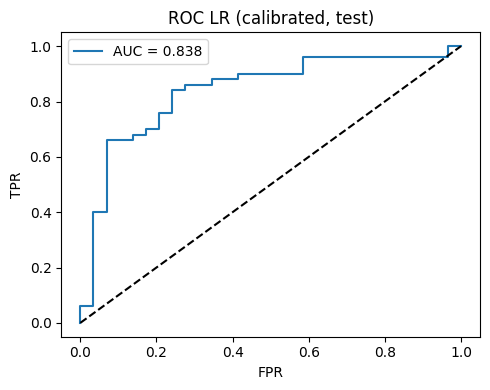

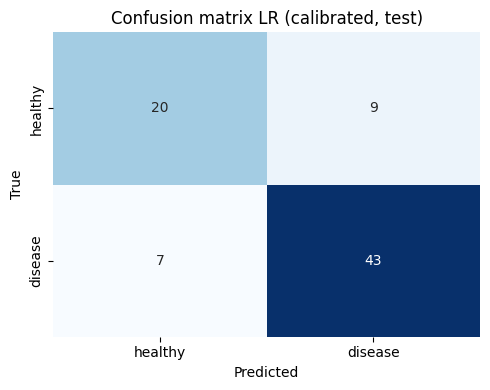

Meilleur seuil (Youden J) LR sur calib: 0.7680 | J=0.7826 | TPR=0.7826 | FPR=0.0000
Rapport LR (calibrated + threshold):
               precision    recall  f1-score   support

     healthy       0.60      0.86      0.70        29
     disease       0.89      0.66      0.76        50

    accuracy                           0.73        79
   macro avg       0.74      0.76      0.73        79
weighted avg       0.78      0.73      0.74        79



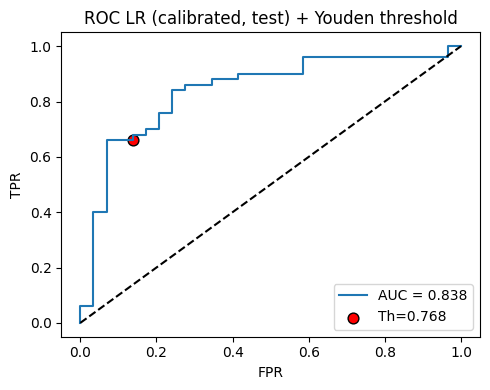

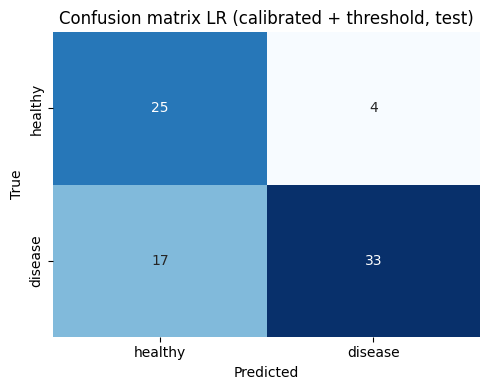


[INFO] Comparaison du rappel (disease): Non-calibre=0.940 vs Calibre+Seuil=0.660
[INFO] Le modele non-calibre est meilleur (ou le seul disponible).
[INFO] Calcul des scores de fold (F1-score) par validation croisee.


c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\ch

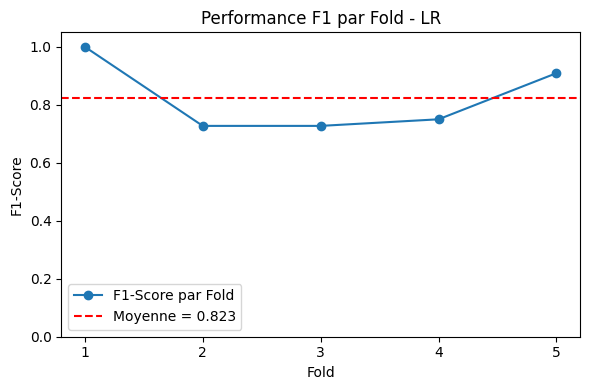

In [12]:
for red in [True,False] : 
    print(f"------> Reduction = {red}")
    # Récupération des résultats
    results_lr = train_with_calibration("lr",X,y,reduction=red)

    # Stockage des résultats complets
    all_results['LR'] = results_lr

    # Affectation de la ligne dans le dataframe
    report_df.loc[len(report_df)] = ["lr",
                                    results_lr["accuracy"],
                                    results_lr["precision"],
                                    results_lr["recall"], 
                                    results_lr["f1-score"], 
                                    results_lr["auc_calibrated"],
                                    results_lr["best_threshold"],
                                    results_lr["mean_fold_scores"],red]


> Random Forest
***

------> Reduction = True
[train_with_calibration] Reduction de features activee (seuil=moyenne): 360 / 1050 features conservees
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Report RF (uncalibrated):
               precision    recall  f1-score   support

     healthy       0.75      0.41      0.53        29
     disease       0.73      0.92      0.81        50

    accuracy                           0.73        79
   macro avg       0.74      0.67      0.67        79
weighted avg       0.74      0.73      0.71        79



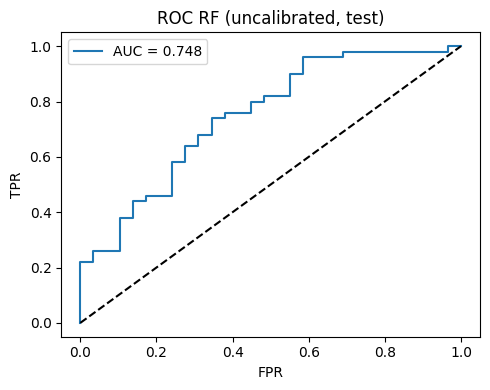

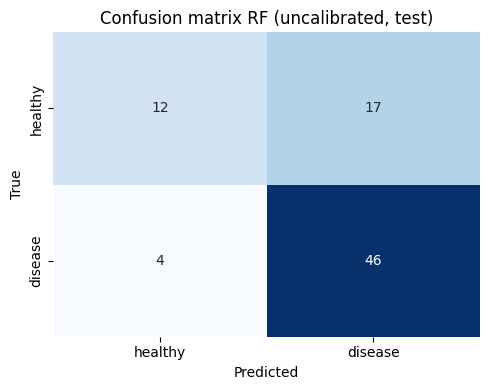

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



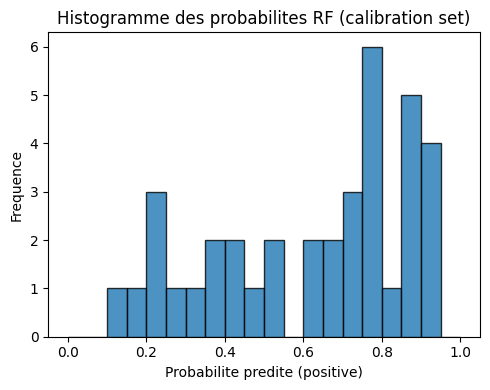

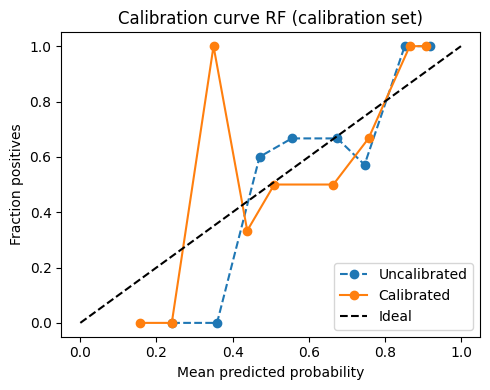

Rapport RF (calibrated):
               precision    recall  f1-score   support

     healthy       0.75      0.80      0.78        50
     disease       0.62      0.55      0.58        29

    accuracy                           0.71        79
   macro avg       0.69      0.68      0.68        79
weighted avg       0.70      0.71      0.71        79



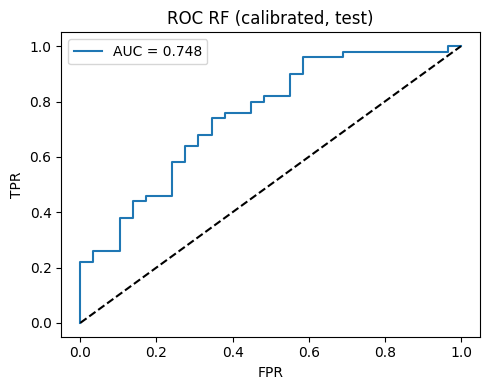

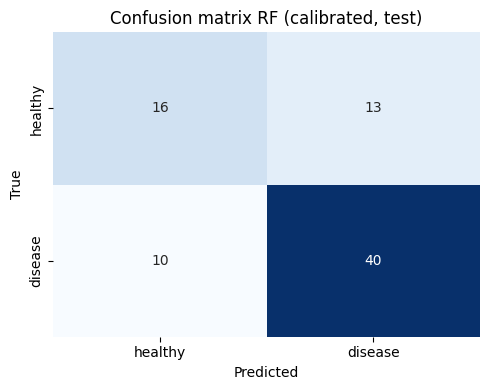

Meilleur seuil (Youden J) RF sur calib: 0.6994 | J=0.5248 | TPR=0.7391 | FPR=0.2143
Rapport RF (calibrated + threshold):
               precision    recall  f1-score   support

     healthy       0.51      0.72      0.60        29
     disease       0.79      0.60      0.68        50

    accuracy                           0.65        79
   macro avg       0.65      0.66      0.64        79
weighted avg       0.69      0.65      0.65        79



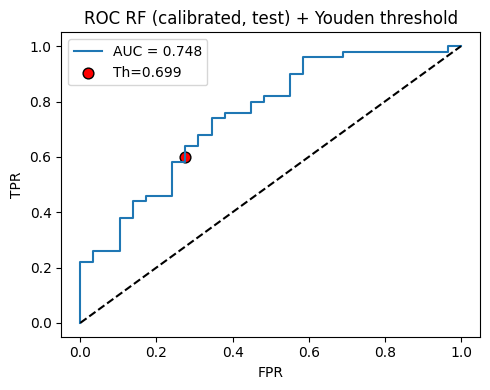

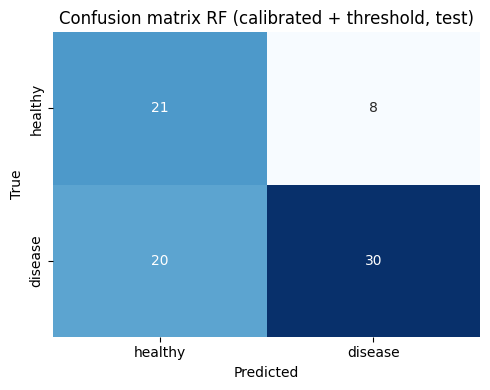


[INFO] Comparaison du rappel (disease): Non-calibre=0.920 vs Calibre+Seuil=0.600
[INFO] Le modele non-calibre est meilleur (ou le seul disponible).
[INFO] Calcul des scores de fold (F1-score) par validation croisee.


c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\ch

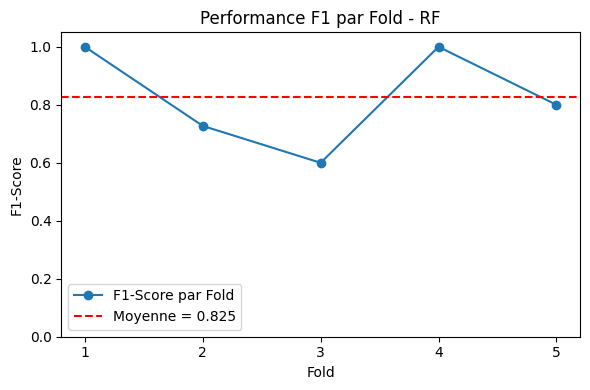

------> Reduction = False
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Report RF (uncalibrated):
               precision    recall  f1-score   support

     healthy       0.81      0.45      0.58        29
     disease       0.75      0.94      0.83        50

    accuracy                           0.76        79
   macro avg       0.78      0.69      0.70        79
weighted avg       0.77      0.76      0.74        79



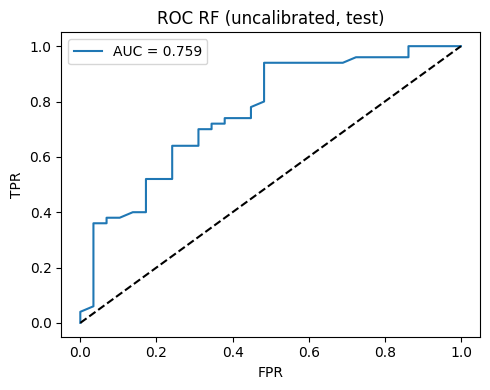

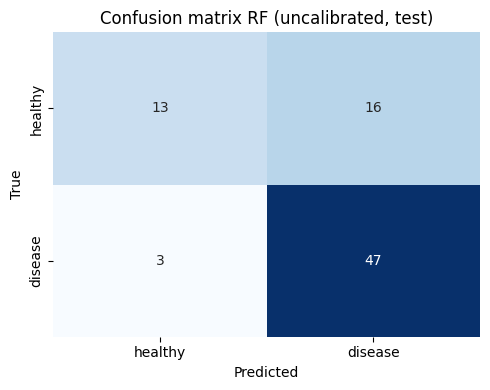

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



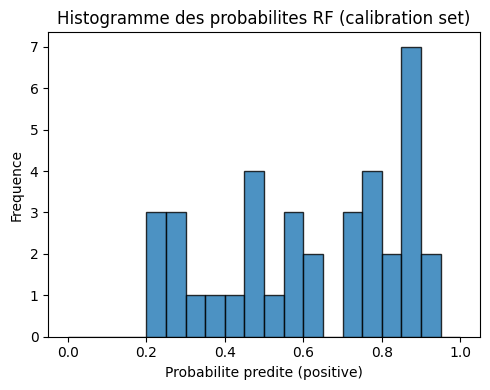

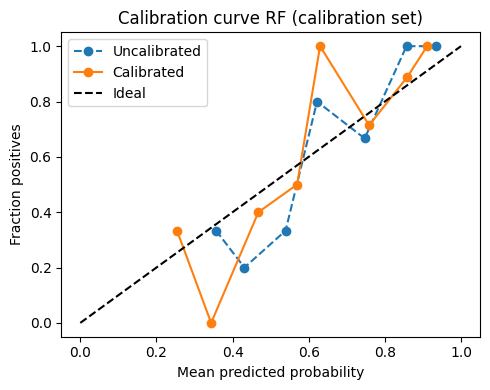

Rapport RF (calibrated):
               precision    recall  f1-score   support

     healthy       0.74      0.80      0.77        50
     disease       0.60      0.52      0.56        29

    accuracy                           0.70        79
   macro avg       0.67      0.66      0.66        79
weighted avg       0.69      0.70      0.69        79



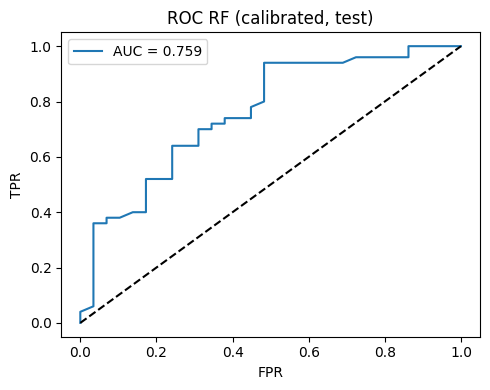

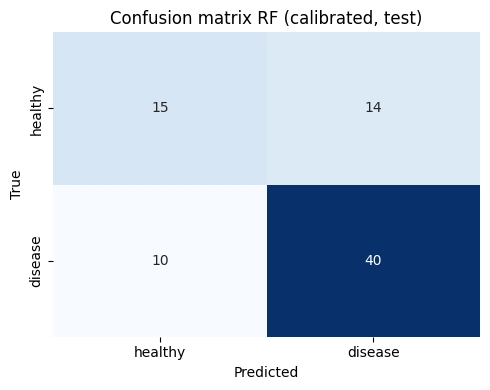

Meilleur seuil (Youden J) RF sur calib: 0.5956 | J=0.6118 | TPR=0.8261 | FPR=0.2143
Rapport RF (calibrated + threshold):
               precision    recall  f1-score   support

     healthy       0.56      0.62      0.59        29
     disease       0.77      0.72      0.74        50

    accuracy                           0.68        79
   macro avg       0.66      0.67      0.67        79
weighted avg       0.69      0.68      0.69        79



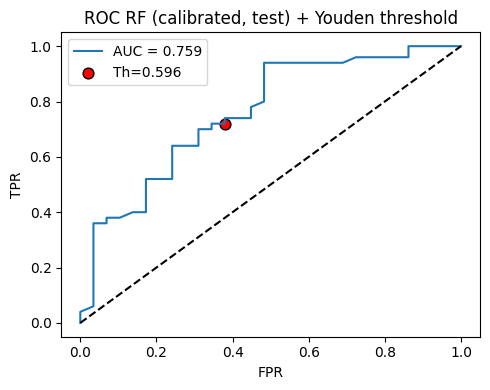

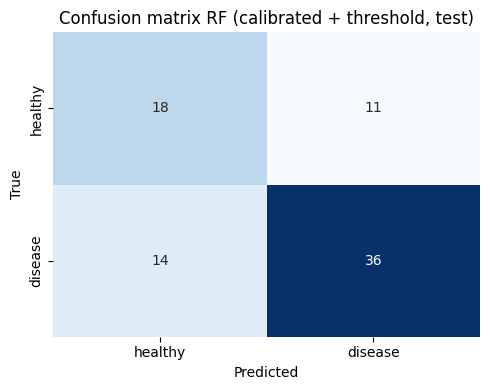


[INFO] Comparaison du rappel (disease): Non-calibre=0.940 vs Calibre+Seuil=0.720
[INFO] Le modele non-calibre est meilleur (ou le seul disponible).
[INFO] Calcul des scores de fold (F1-score) par validation croisee.


c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\chinese_microbiome\fonctions_utiles.py:974: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\Marc2\OneDrive\Documents\M2 MLB\ch

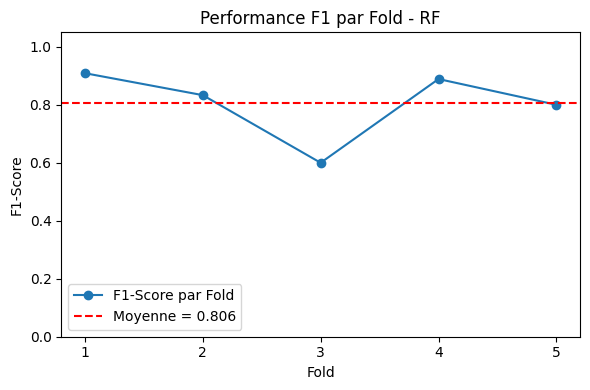

In [13]:
for red in [True,False] : 
    print(f"------> Reduction = {red}")
    # Récupération des résultats
    results_rf = train_with_calibration("rf",X,y,reduction=red)

    # Stockage des résultats complets
    all_results['RF'] = results_rf

    # Affectation de la ligne dans le dataframe
    report_df.loc[len(report_df)] = ["rf",
                                    results_rf["accuracy"],
                                    results_rf["precision"],
                                    results_rf["recall"], 
                                    results_rf["f1-score"], 
                                    results_rf["auc_calibrated"],
                                    results_rf["best_threshold"],
                                    results_rf["mean_fold_scores"],red]

> XGBoost
***

------> Reduction = True
[train_with_calibration] Reduction de features activee (seuil=moyenne): 360 / 1050 features conservees
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:199: UserWarning:

[16:00:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Report XGB (uncalibrated):
               precision    recall  f1-score   support

     healthy       0.59      0.34      0.43        29
     disease       0.69      0.86      0.77        50

    accuracy                           0.67        79
   macro avg       0.64      0.60      0.60        79
weighted avg       0.65      0.67      0.65        79



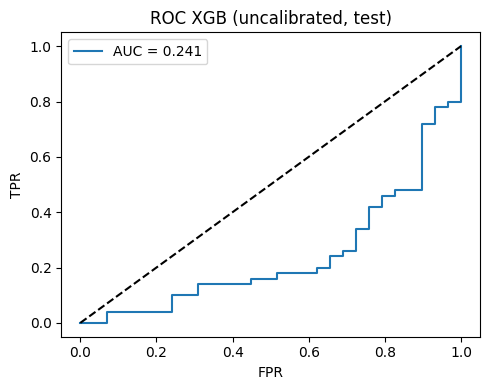

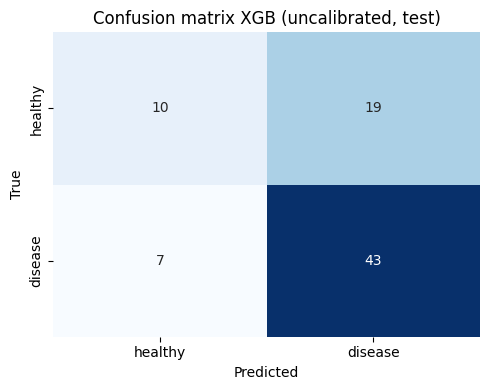

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning:

The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.



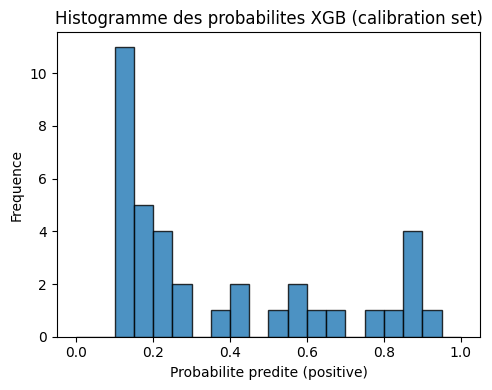

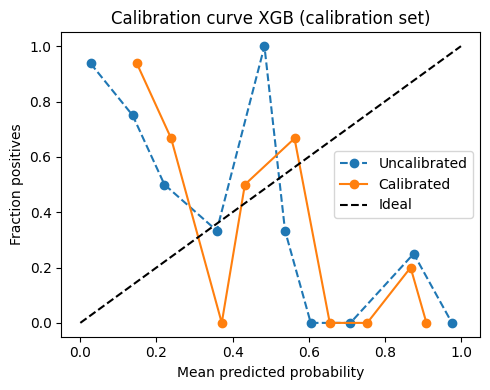

Rapport XGB (calibrated):
               precision    recall  f1-score   support

     healthy       0.72      0.84      0.78        50
     disease       0.62      0.45      0.52        29

    accuracy                           0.70        79
   macro avg       0.67      0.64      0.65        79
weighted avg       0.69      0.70      0.68        79



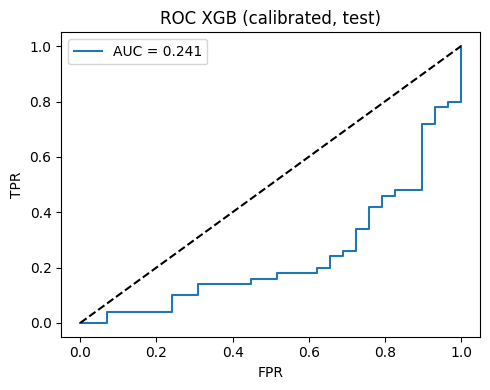

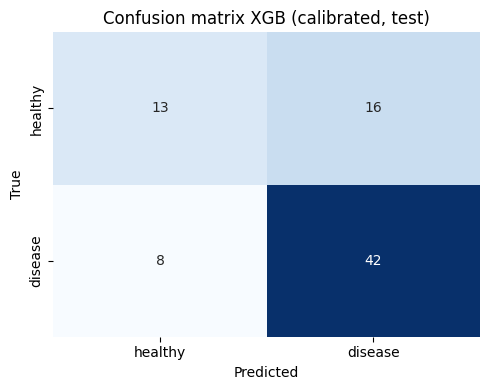

Meilleur seuil (Youden J) XGB sur calib: inf | J=0.0000 | TPR=0.0000 | FPR=0.0000
Rapport XGB (calibrated + threshold):
               precision    recall  f1-score   support

     healthy       0.63      1.00      0.78        50
     disease       0.00      0.00      0.00        29

    accuracy                           0.63        79
   macro avg       0.32      0.50      0.39        79
weighted avg       0.40      0.63      0.49        79



C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

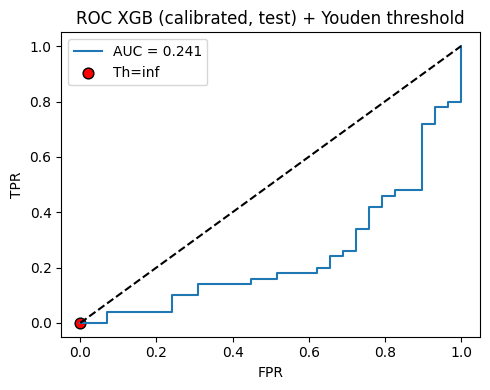

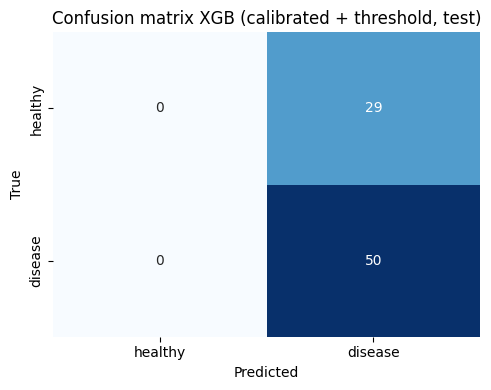

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa


[INFO] Comparaison du rappel (disease): Non-calibre=0.860 vs Calibre+Seuil=1.000
[INFO] Le modele calibre est meilleur ou equivalent.
[INFO] Calcul des scores de fold (F1-score) par validation croisee.


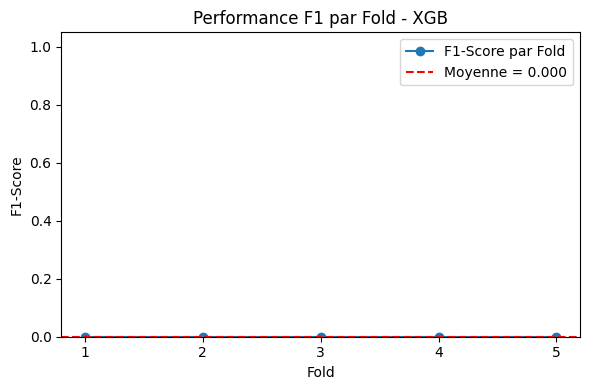

------> Reduction = False
Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [14]:
for red in [True,False] : 
    print(f"------> Reduction = {red}")
    # Récupération des résultats
    results_xgb = train_with_calibration("xgb",X,y,reduction=red)

    # Stockage des résultats complets
    all_results['XGB'] = results_xgb

    # Affectation de la ligne dans le dataframe
    report_df.loc[len(report_df)] = ["xgb",
                                    results_xgb["accuracy"],
                                    results_xgb["precision"],
                                    results_xgb["recall"], 
                                    results_xgb["f1-score"], 
                                    results_xgb["auc_calibrated"],
                                    results_xgb["best_threshold"],
                                    results_xgb["mean_fold_scores"],red]

In [ ]:
### Comparaison Inter-Modèles : Courbes ROC

plt.figure(figsize=(8, 7))

for model_name, results in all_results.items():
    if results.get('fpr') is not None and results.get('tpr') is not None:
        auc = results.get('auc_calibrated', 0.0)
        plt.plot(results['fpr'], results['tpr'], label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.5)')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Comparaison des Courbes ROC des Modèles')
plt.legend()
plt.grid(True)
plt.savefig("model_comparison/roc_curves_comparison.png", bbox_inches='tight')
plt.show()


In [ ]:
# Affichage du tableau de comparaison
display(report_df)

# Sauvegarde du rapport en fichier CSV
report_df.to_csv('model_comparison_report.csv', index=False)
print("\nRapport sauvegardé dans 'model_comparison_report.csv'")


### Conclusion

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fdffc1-05e0-4036-8d4f-2c2229b70573' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>